[1.000000e-04 1.023293e-04 1.047129e-04 1.071519e-04 1.096478e-04
 1.122018e-04 1.148154e-04 1.174898e-04 1.202264e-04 1.230269e-04
 1.258925e-04 1.288250e-04 1.318257e-04 1.348963e-04 1.380384e-04
 1.412538e-04 1.445440e-04 1.479108e-04 1.513561e-04 1.548817e-04
 1.584893e-04 1.621810e-04 1.659587e-04 1.698244e-04 1.737801e-04
 1.778279e-04 1.819701e-04 1.862087e-04 1.905461e-04 1.949845e-04
 1.995262e-04 2.041738e-04 2.089296e-04 2.137962e-04 2.187762e-04
 2.238721e-04 2.290868e-04 2.344229e-04 2.398833e-04 2.454709e-04
 2.511886e-04 2.570396e-04 2.630268e-04 2.691535e-04 2.754229e-04
 2.818383e-04 2.884032e-04 2.951209e-04 3.019952e-04 3.090295e-04
 3.162278e-04 3.235937e-04 3.311311e-04 3.388442e-04 3.467369e-04
 3.548134e-04 3.630781e-04 3.715352e-04 3.801894e-04 3.890451e-04
 3.981072e-04 4.073803e-04 4.168694e-04 4.265795e-04 4.365158e-04
 4.466836e-04 4.570882e-04 4.677351e-04 4.786301e-04 4.897788e-04
 5.011872e-04 5.128614e-04 5.248075e-04 5.370318e-04 5.495409e-04
 5.623413e

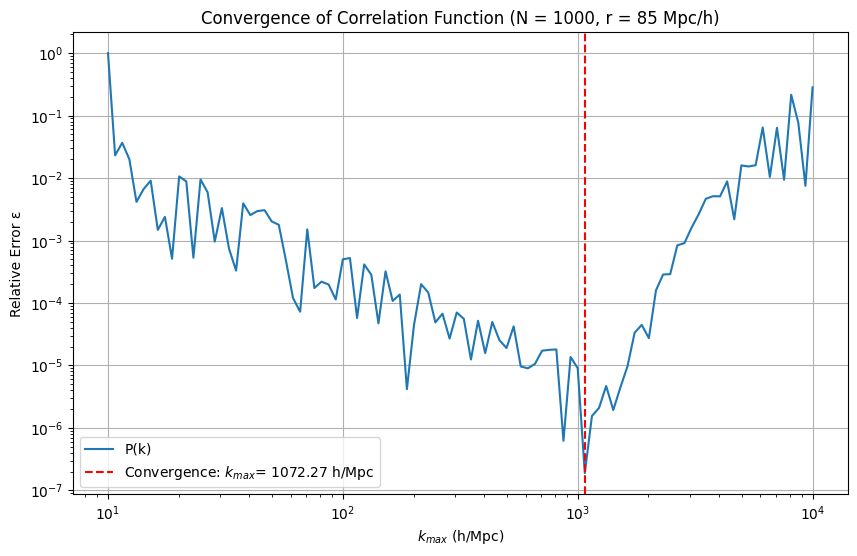

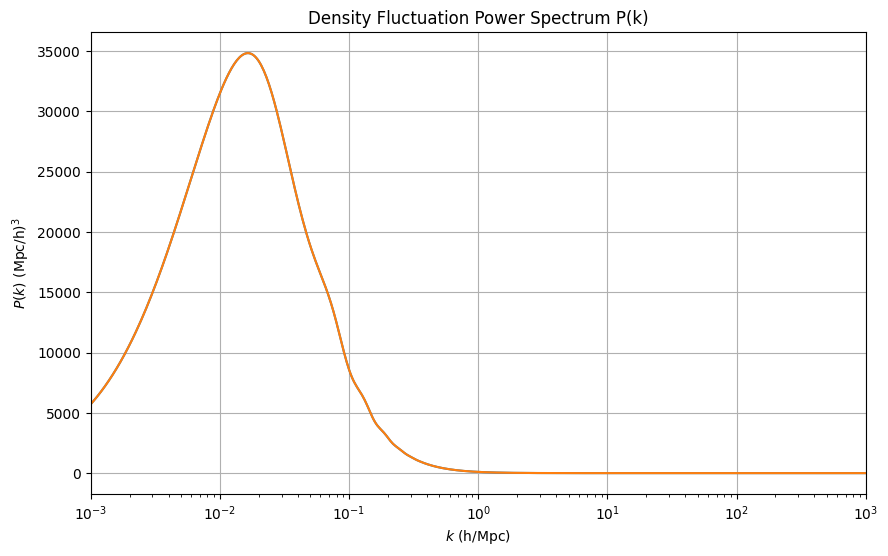

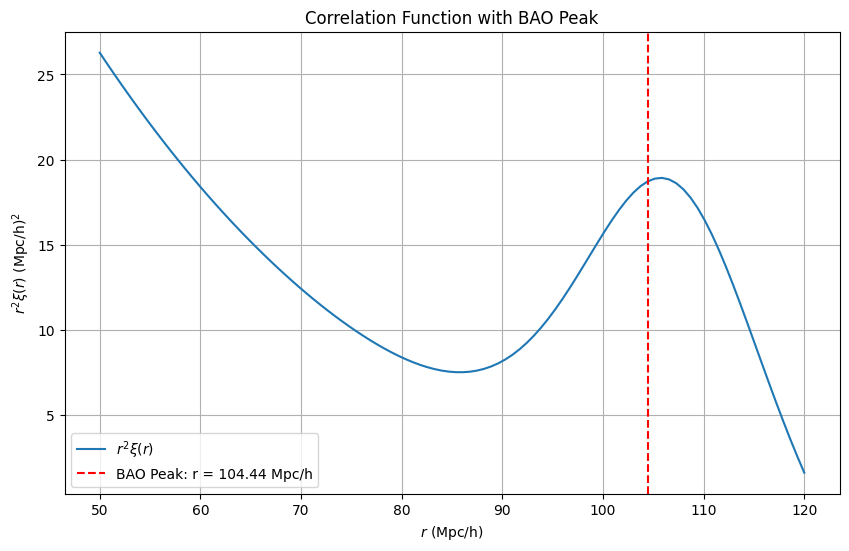

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import quad, simpson
import numba

def int_exp_simpson(f, h, max):
    odd_interval = np.linspace(h, max - h, int(max / (2 * h)))
    even_interval = np.linspace(2 * h, max - 2 * h, int(max / (2 * h)))
    return 1/3 * h * (0 + f(max) + 4 * np.sum(f(odd_interval)) + 2 * np.sum(f(even_interval)))

@numba.njit(parallel=True)
def int_simpson(f, N, max):
    h = np.float32(max / N)
    result = f(0) + f(max)
    for i in numba.prange(N - 1):
        if (i + 1) % 2 == 0:
            result += np.float32(2) * np.float32(f(-(i + 1) * h))
        else:
            result += np.float32(4) * np.float32(f(-(i + 1) * h))
    return np.float32(result * h / 3.0)

def convergence_test(g, max, N):
    errors = np.zeros(len(max))
    integrals = np.zeros(len(max))
    integrals[0] = int_exp_simpson(g, 1.0 / N, max[0])
    errors[0] = 1
    for i in np.arange(1, len(max)):
        integrals[i] = int_exp_simpson(g, 1.0 / N, max[i])
        errors[i] = np.abs(integrals[i] - integrals[i-1]) / integrals[i-1]
    return errors
# Load the tabulated power spectrum data
data = np.loadtxt('lcdm_z0.matter_pk')
k = data[:, 0]  # First column: wavenumber k
P_k = data[:, 1]  # Second column: power spectrum P(k)

print(k)
k = np.append(0, k)
P_k = np.append(0, P_k)
# Define the correlation function ξ(r)

def integrand_const(k_0, r = 85):
    spline = CubicSpline(k, P_k, bc_type = ('natural', 'not-a-knot'))
    P_k_interp = spline(k_0)
    return k_0**2 * P_k_interp * np.sin(k_0 * r) / (k_0 * r)


def xi_r(r, k, P_k):
    # Interpolate P(k) using cubic spline
    spline = CubicSpline(k, P_k, bc_type = ('natural', 'not-a-knot'))

    def integrand(k):
        P_k_interp = spline(k)
        return k**2 * P_k_interp * np.sin(k * r) / (k * r)
    # Integrand for ξ(r)    
    # Perform the integral
    # integral, _ = quad(integrand, 0, k[-1])  # Integrate over the range of k
    integral = int_exp_simpson(integrand, 1e-3, 2e3)
    return integral / (2 * np.pi**2)

def xi_r_max_test(k):
    return xi_r(100, k, P_k, max, N=1000)

# Compute ξ(r) for r in the range [50, 120] Mpc/h
r_values = np.linspace(50, 120, 100)
xi_values = np.array([xi_r(r, k, P_k) for r in r_values])
r2_xi_values = r_values**2 * xi_values
# Compute r^2 * ξ(r) for visualization

# Find the scale of the peak (BAO peak)
peak_index = np.argmax(xi_values[60:])
bao_peak_scale = r_values[peak_index + 60]

max_values = np.logspace(1, 4, 100)
err_values = convergence_test(integrand_const, max_values, 1e3)
min_err = np.argmin(err_values)
best_k = max_values[min_err]
plt.figure(figsize=(10, 6))
plt.loglog(max_values, err_values, label='P(k)')
plt.xlabel(r'$k_{max}$ (h/Mpc)')
plt.axvline(best_k, color='red', linestyle='--', label=f'Convergence: ' + r'$k_{max}$' + f'= {best_k:.2f} h/Mpc')
plt.ylabel('Relative Error ε')
plt.title('Convergence of Correlation Function (N = 1000, r = 85 Mpc/h)')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

spline = CubicSpline(k, P_k, bc_type = ('natural', 'not-a-knot'))

plt.figure(figsize=(10, 6))
plt.plot(k, P_k, label='P(k)')
plt.plot(k, spline(k), label='P(k)')
plt.xlabel(r'$k$ (h/Mpc)')
plt.ylabel(r'$P(k)$ (Mpc/h)$^3$')
plt.title('Density Fluctuation Power Spectrum P(k)')
plt.xlim(1e-3, 1e3)
plt.xscale('log')
plt.grid(True)
plt.show()


# Plot r^2 * ξ(r)
plt.figure(figsize=(10, 6))
plt.plot(r_values, r2_xi_values , label=r'$r^2 \xi(r)$')
plt.axvline(bao_peak_scale, color='red', linestyle='--', label=f'BAO Peak: r = {bao_peak_scale:.2f} Mpc/h')
plt.xlabel(r'$r$ (Mpc/h)')
plt.ylabel(r'$r^2 \xi(r)$ (Mpc/h)$^2$')
plt.title('Correlation Function with BAO Peak')
plt.legend()
plt.grid(True)
plt.show()